# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

In [1]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [54]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)
    
    logits = self.graph.get_tensor_by_name('ResizeBilinear_1:0')[:, :513, :513]
    logits = tf.image.resize_images(logits, (256, 256), method=tf.image.ResizeMethod.BILINEAR, align_corners=True)
    self.logits = logits
    
    print(self.logits.shape)
    
  def run(self, image, logits=True):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.logits,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [4]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'cityspace'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    'cityspace':
        'deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz'
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)
download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')


downloading model, this might take a while...
download completed! loading DeepLab model...


NameError: name 'MODEL' is not defined

In [55]:
download_path='/tmp/tmpo9ecjb1s/deeplab_model.tar.gz'
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

(1, 256, 256, 19)
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that we are using single scale inference in the demo for fast computation,
so the results may slightly differ from the visualizations in
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md),
which uses multi-scale and left-right flipped inputs.

In [6]:
from tqdm import tqdm_notebook

In [111]:
MT_PATH = '/data/pytorch-CycleGAN-and-pix2pix/results2/c16r8_all/test_latest/images/cityscapes_test_%d_fake_A.png'
ST_PATH = '/data/pytorch-CycleGAN-and-pix2pix/results2/cityscapes_baseline/test_latest/images/%d_fake_A.png'
import skimage.transform
def evaluate_folders(path, gts, n = 500, group=None):
    #segs = []
    for i in tqdm_notebook(range(1, n + 1)):
        p = path % i
        #print(p)
        original_im = Image.open(p)
        resized_im, seg_map = MODEL.run(original_im)
        #segs.append(seg_map)
        
        if '%d' % i not in group:
            group.create_dataset('%d/accuracy' % i, data=accuracy(gts[i - 1], seg_map))
            group.create_dataset('%d/nll' % i, data=log_prob(gts[i - 1], seg_map))
    #return segs

def load_groundtruth(path):
    segs = []
    for i in tqdm_notebook(range(1, 500 + 1)):
        p = path % i
        p = p.replace('fake_A', 'real_B')
        #print(p)
        segs.append(np.array(Image.open(p)))
    return segs

import scipy.ndimage
def accuracy(ground_truth, predictions):
    predictions = np.argmax(predictions, axis=-1)
    #predictions = skimage.transform.resize(predictions, (256, 256), order=0, preserve_range=True, anti_aliasing=False)
    mask = (ground_truth <= 18)
    return np.sum((ground_truth == predictions) * mask) / np.sum(mask)

def onehot(label, n):
    s = label.shape
    label = label.flatten()
    y = np.zeros((label.shape[0], n))
    y[np.arange(0, y.shape[0], dtype=np.int), label.astype(np.int)] = 1
    return y.reshape(s + (n,))

def cross_entropy_with_logits(logits, y_true):
    # y_i *log(e^x_i / \sum_i e^x_i)
    logits = logits - np.max(logits)
    return np.sum(logits * y_true, axis=-1) - np.log(np.sum(np.exp(logits), axis=-1))
    

def log_prob(ground_truth, predictions):
    mask = (ground_truth <= 18)
    gt = np.where(mask, ground_truth, 0)
    nll = -np.sum(cross_entropy_with_logits(predictions, onehot(gt, 19)) * mask) / np.sum(mask)
    return nll

In [112]:
import h5py
import cityscapesscripts
from cityscapesscripts.helpers import labels
import numpy as np
from collections import defaultdict
class Label:
    def __init__(self):
        self.color_map = {}
        self.id_map = defaultdict(lambda : -1)
        for l in labels.labels:
            self.color_map[l.trainId] = l.color
            self.id_map[l.color] = l.trainId
        self.color_map_arr = np.array([self.color_map[i] for i in range(19)])
    def convert_image(self, label):
        s = label.shape
        mask = (label != 255)
        label = np.where(mask, label, 0)
        rgb = np.take(self.color_map_arr, label.flatten(), axis=0).reshape(s + (3,))
        rgb = np.where(np.expand_dims(mask, 2), rgb, [[(0, 0, 0)]])
        return rgb
    def convert_label(self, rgb, th=10):
        rgb = np.array(rgb)
        s = rgb.shape[:2]
        
        dist = np.linalg.norm(rgb.reshape((-1, 1, 3)) - self.color_map_arr.reshape(1, -1, 3), axis=-1)
        cdist = np.min(dist, axis=-1)
        label = np.argmin(dist, axis=-1)
        label = np.where(cdist < th, label, 255)
        
        return label.reshape(s)
l = Label()

In [19]:
gt_segs = load_groundtruth(MT_PATH)
gt_ids = [ l.convert_label(seg, th=40) for seg in gt_segs]

In [ ]:
with h5py.File('/data/pytorch-CycleGAN-and-pix2pix/results2/eval-result.h5', 'w') as df:
    ns = 500
    evaluate_folders(MT_PATH, gt_ids, n = ns, group=df.require_group('mt'))
    evaluate_folders(ST_PATH, gt_ids, n = ns, group=df.require_group('st'))
    evaluate_folders(MT_PATH.replace('fake_A', 'real_A'), gt_ids, n = ns, group=df.require_group('real'))

In [114]:
import pandas as pd
with h5py.File('/data/pytorch-CycleGAN-and-pix2pix/results2/eval-result.h5', 'r') as df:
    records = []
    for method in df:
        print(method)
        for sample in df[method]:
            entry = {k : v.value for k, v in df[method][sample].items()}
            entry['method'] = method
            entry['sample'] = sample
            records.append(entry)
    df = pd.DataFrame(records)

mt
real
st


In [116]:
df.groupby('method').mean()

,accuracy,nll
method,,
mt,0.617228,1.759269
real,0.893673,0.448927
st,0.519278,2.180508


In [36]:
op = MODEL.graph.get_operation_by_name('ArgMax')

In [37]:
op

<tf.Operation 'ArgMax' type=ArgMax>

In [38]:
op.inputs[0]

<tf.Tensor 'ResizeBilinear_1:0' shape=(1, 1025, 2049, 19) dtype=float32>

In [49]:
MODEL.graph.get_tensor_by_name('ResizeBilinear_1:0')

<tf.Tensor 'ResizeBilinear_1:0' shape=(1, 1025, 2049, 19) dtype=float32>

In [48]:
MODEL.graph.get_tensor_by_name('ResizeBilinear:0')

<tf.Tensor 'ResizeBilinear:0' shape=(1, 257, 513, 19) dtype=float32>

In [46]:
MODEL.graph.get_tensor_by_name('logits/semantic/BiasAdd:0')

<tf.Tensor 'logits/semantic/BiasAdd:0' shape=(1, 257, 513, 19) dtype=float32>

In [80]:
np.mean(list(map(accuracy, gt_ids, gt_preds)))

In [218]:
np.mean(list(map(accuracy, gt_ids, seg_mt))), np.mean(list(map(accuracy, gt_ids, seg_st)))

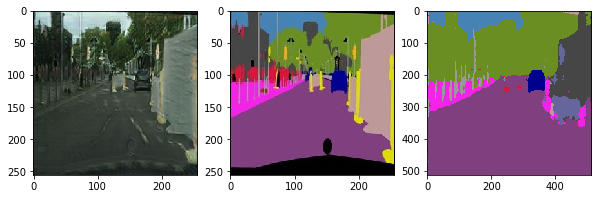

In [102]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
path = '/data/pytorch-CycleGAN-and-pix2pix/datasets/cityscapes/testA/100_A.jpg'
path = '/data/pytorch-CycleGAN-and-pix2pix/results/c16r8_all/test_latest/images/cityscapes_testA_100_A_fake_A.png'
#path = '/data/pytorch-CycleGAN-and-pix2pix/results2/cityscapes_baseline/test_latest/images/101_A_real_A.png'
original_im = Image.open(path)
plt.imshow(original_im)
plt.subplot(132)
path = '/data/pytorch-CycleGAN-and-pix2pix/datasets/cityscapes/testB/100_B.jpg'
#path = '/data/pytorch-CycleGAN-and-pix2pix/results2/cityscapes_baseline/test_latest/images/101_A_real_B.png'
original_seg = Image.open(path)
plt.imshow(original_seg)
def run_visualization(original_im):
  resized_im, seg_map = MODEL.run(original_im)
  return resized_im, seg_map
  #vis_segmentation(resized_im, seg_map)
rim, seg_map = run_visualization(original_im)
plt.subplot(133)
plt.imshow(l.convert_image(seg_map))

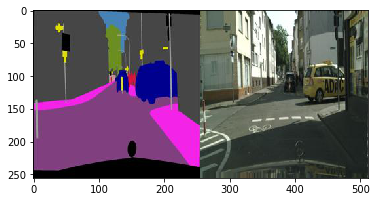

In [117]:
dt=np.array(Image.open('/data/pytorch-CycleGAN-and-pix2pix/datasets/cityscapes/evaluate_cityscape/frankfurt_000000_000294_leftImg8bit.jpg'))
plt.imshow(dt)